In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import mplhep as hep
import matplotlib.colors as mcolors
from scipy.stats import linregress
from scipy.optimize import curve_fit
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.optimize import curve_fit

In [3]:
with open('../../genIII_data/JLab/Beam/1-63-60-Beam.txt') as f:
    lines = f.read().split('\n')
tags = None
IDs=[]
layers=[]
channels =[]
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue

    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;

    split = line.split()
    layer, channel, LG, HG = split[0:4]

    ID=int(layer)*64+int(channel)

    if ID not in IDs:
        din[f"{ID}_LG"] = []
        din[f"{ID}_HG"] = []
        IDs.append(ID)
    din[f"{ID}_LG"].append(float(LG))
    din[f"{ID}_HG"].append(float(HG))

In [9]:
def linear(x, m, b):
    return m * x + b

def analyze_gain_ratios_unit(din, caen_unit, GainRatios):
    num_channels = 64
    num_cols = 8
    num_rows = num_channels // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    for i in range(num_channels):
        ID = i + caen_unit * 64
        lg = np.array(din.get(f"{ID}_LG", []))
        hg = np.array(din.get(f"{ID}_HG", []))

        # Updated mask
        mask = (
            (lg > 300) &
            (hg > 700) &
            (hg < 8000) &
            np.isfinite(lg) &
            np.isfinite(hg)
        )
        lg = lg[mask]
        hg = hg[mask]

        ax = axes[i]

        if len(lg) > 10:
            # Plot histogram
            h = ax.hist2d(
                lg, hg,
                bins=50,
                range=[(0, 1000), (0, 8000)],
                cmap='viridis',
                norm=mcolors.LogNorm()
            )

            # Fit
            try:
                popt, _ = curve_fit(linear, lg, hg, p0=[8, 0], bounds=([5, -np.inf], [15, np.inf]))
                m_fit, b_fit = popt
                GainRatios.append(m_fit)
                
                # Plot fitted line
                x_fit = np.linspace(300, 1000, 100)
                y_fit = linear(x_fit, *popt)
                ax.plot(x_fit, y_fit, color='red', lw=1, label=f"Slope = {round(m_fit,2)}")
                ax.legend()
            except (RuntimeError, ValueError):
                GainRatios.append(0.0)
        else:
            GainRatios.append(0.0)
            ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                    ha='center', va='center', fontsize=8)

        if i % num_cols == 0:
            ax.set_ylabel("HG")
        if i >= num_channels - num_cols:
            ax.set_xlabel("LG")

    plt.tight_layout(pad=0.0)
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(wspace=0, hspace=0)
    

    # Only try to add colorbar if at least one plot succeeded
    try:
        cbar = fig.colorbar(h[3], ax=axes.ravel().tolist(), shrink=0.6)
        cbar.set_label("Counts")
    except:
        pass

    plt.suptitle(f"HG vs LG Gain Ratios (Unit {caen_unit})", y=1.02, fontsize=16)
    plt.show()

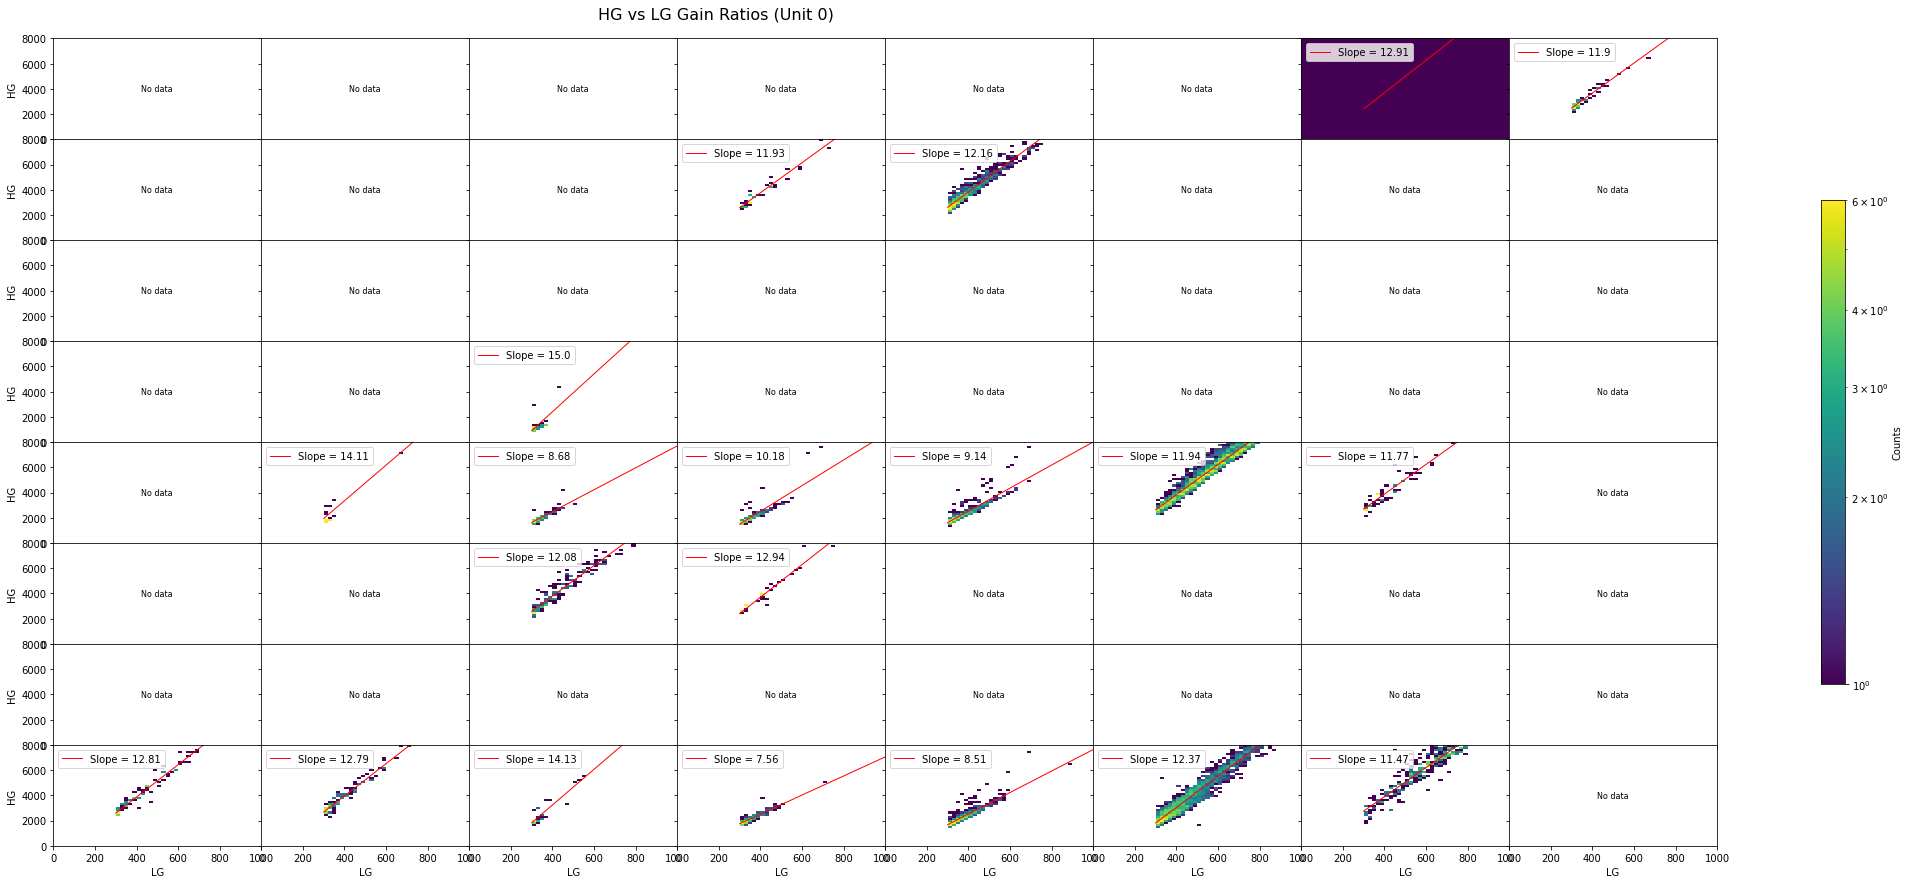

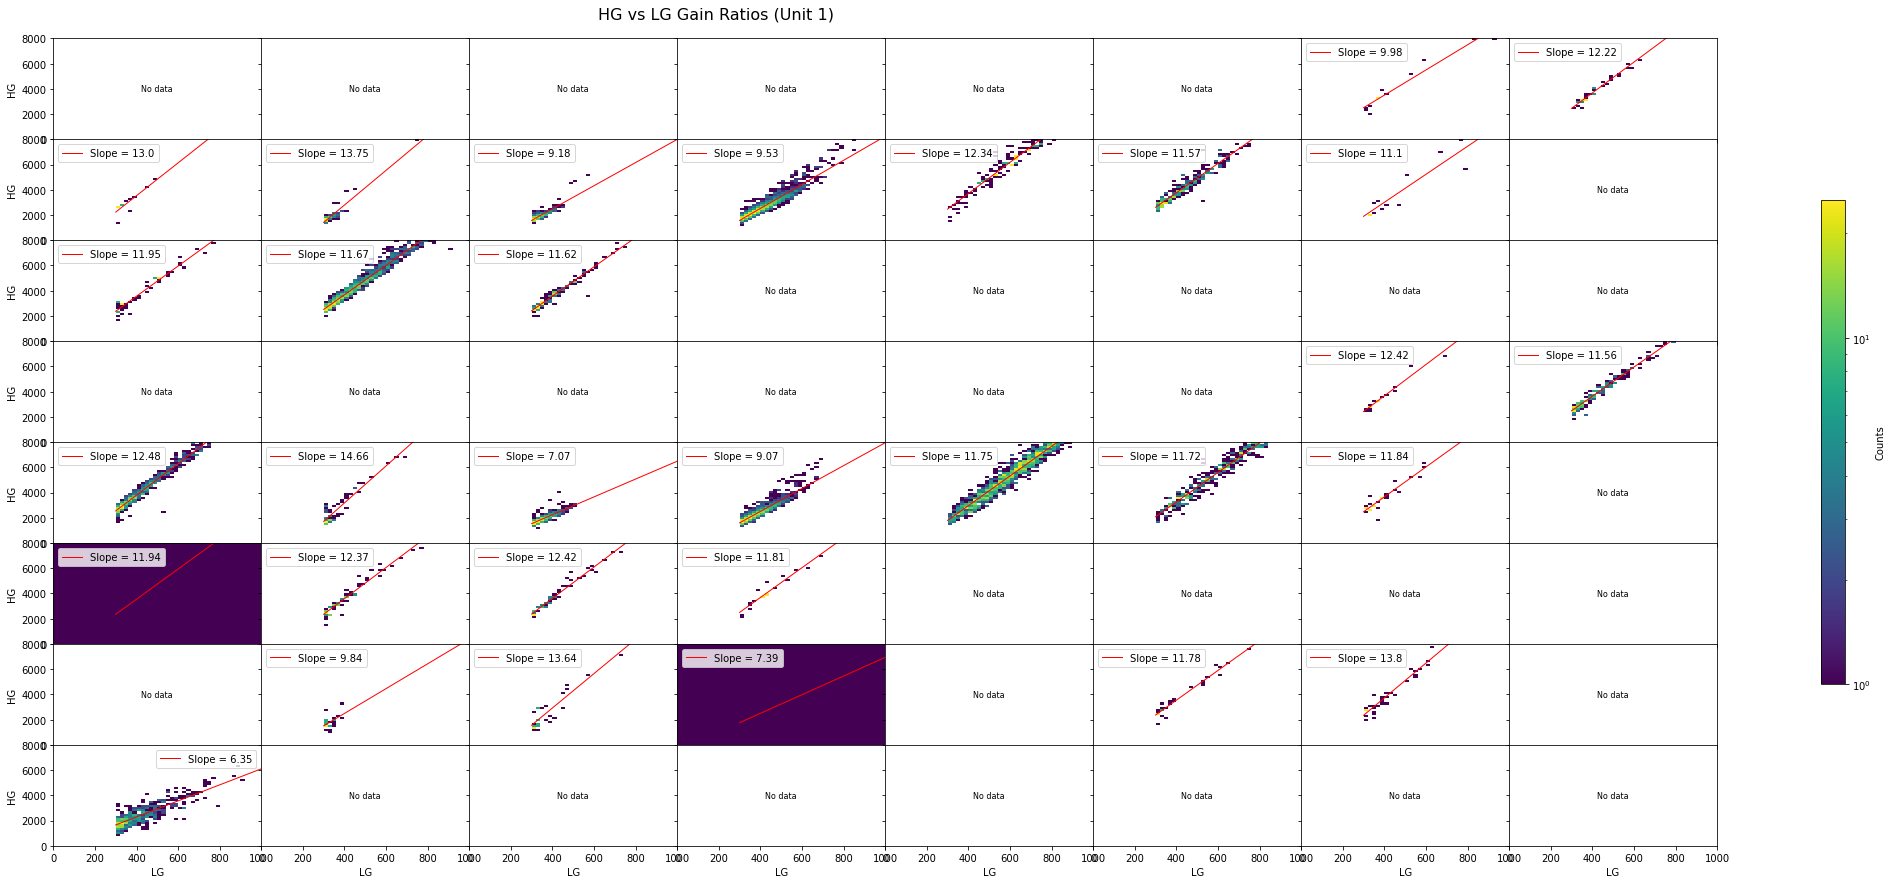

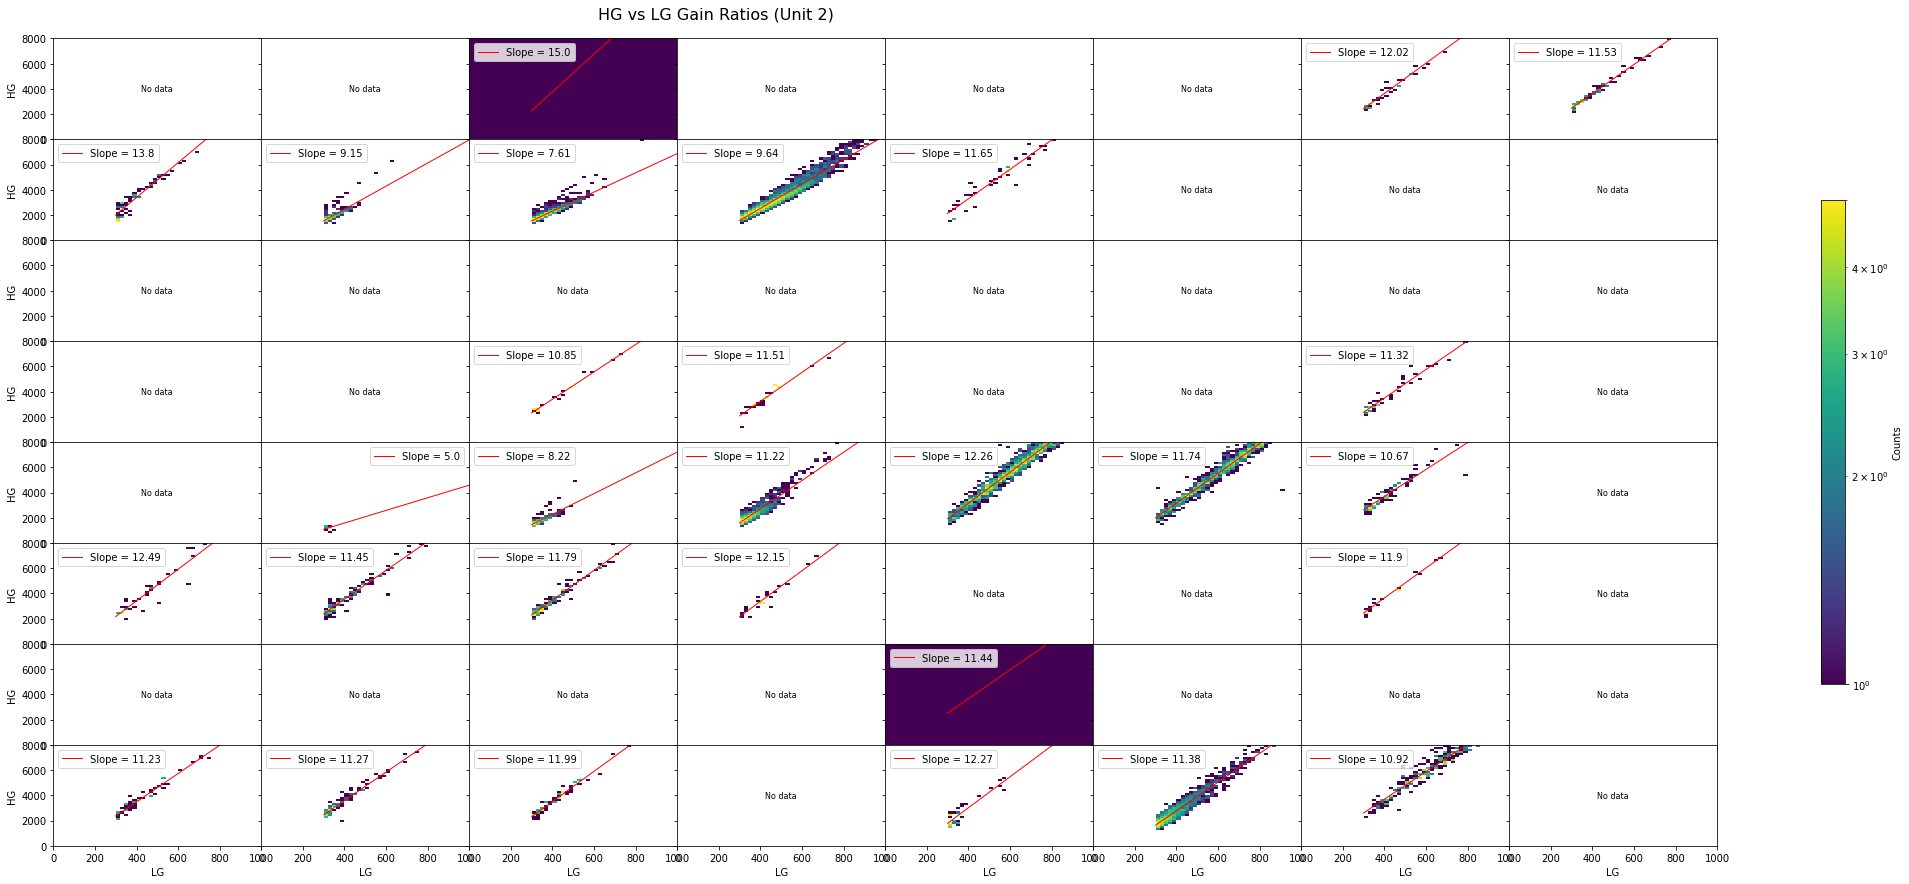

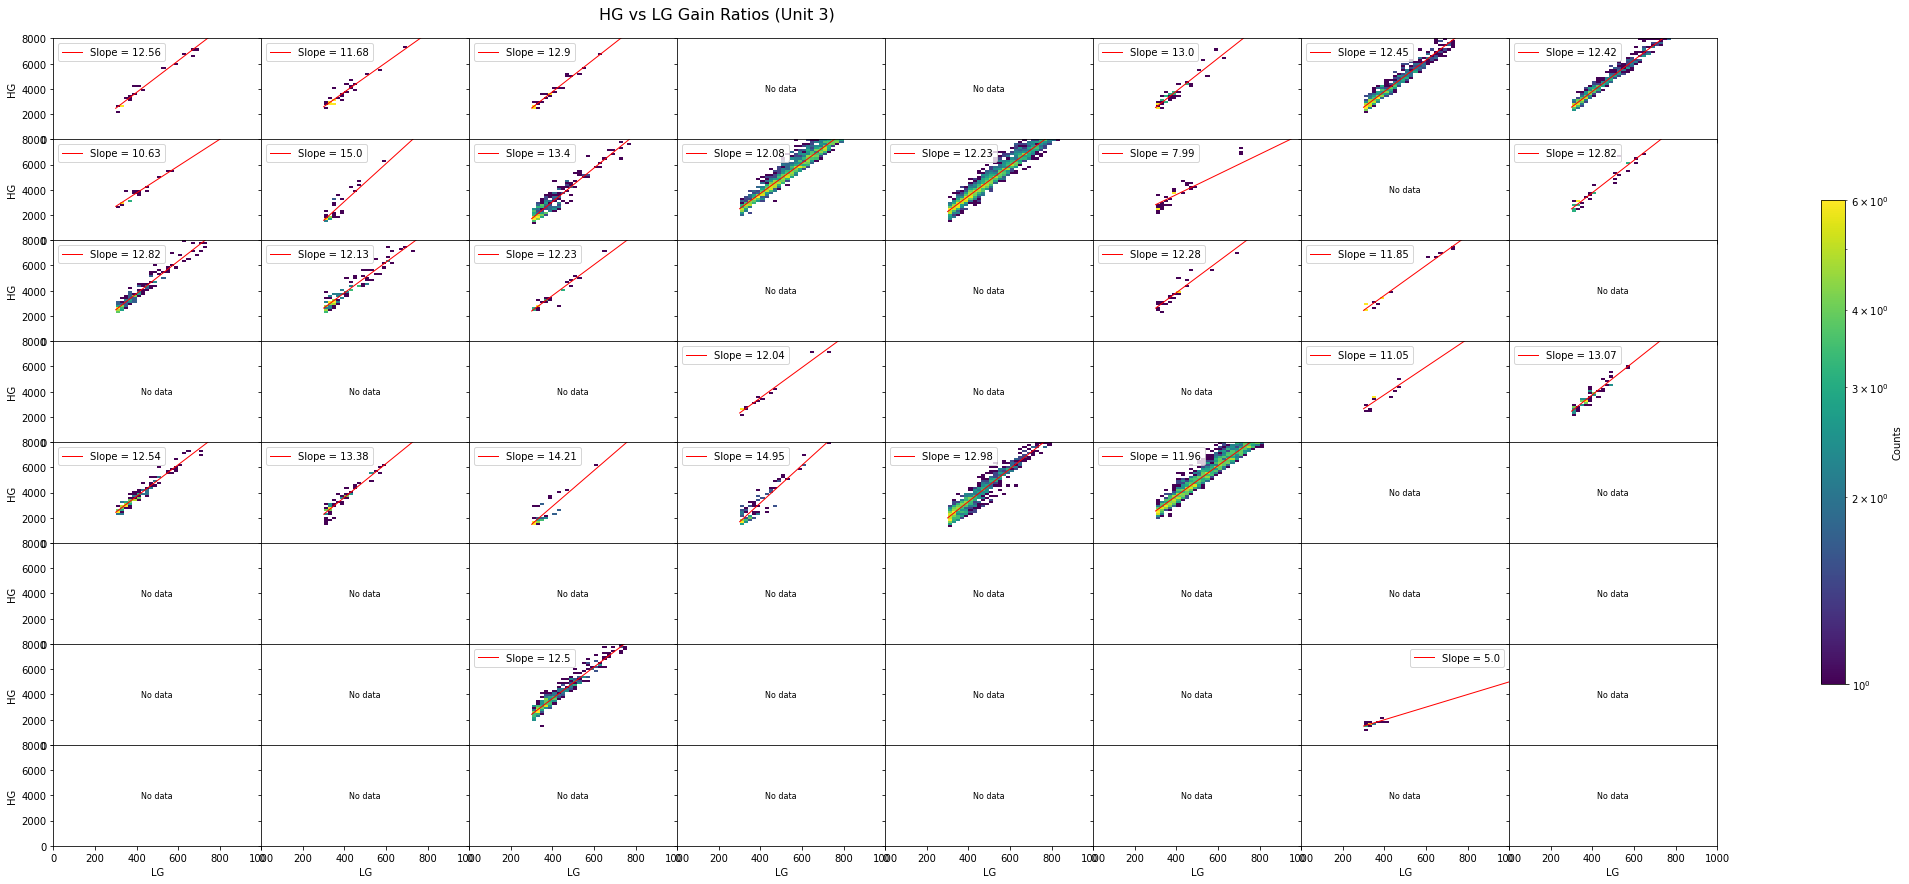

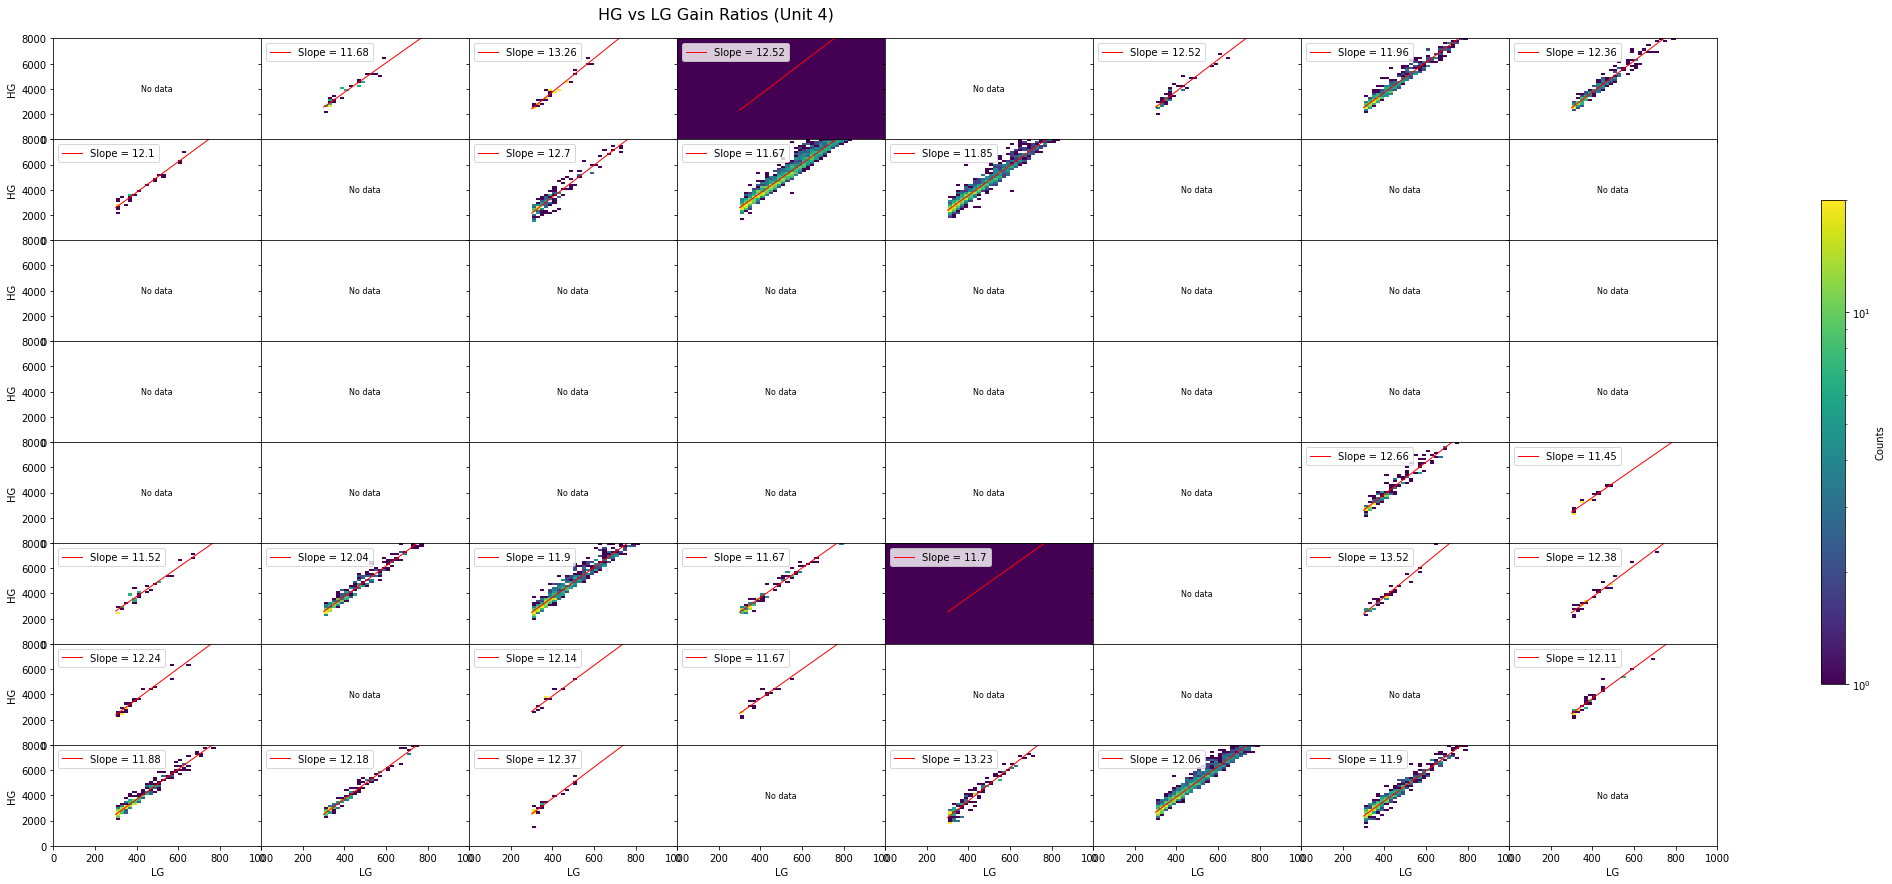

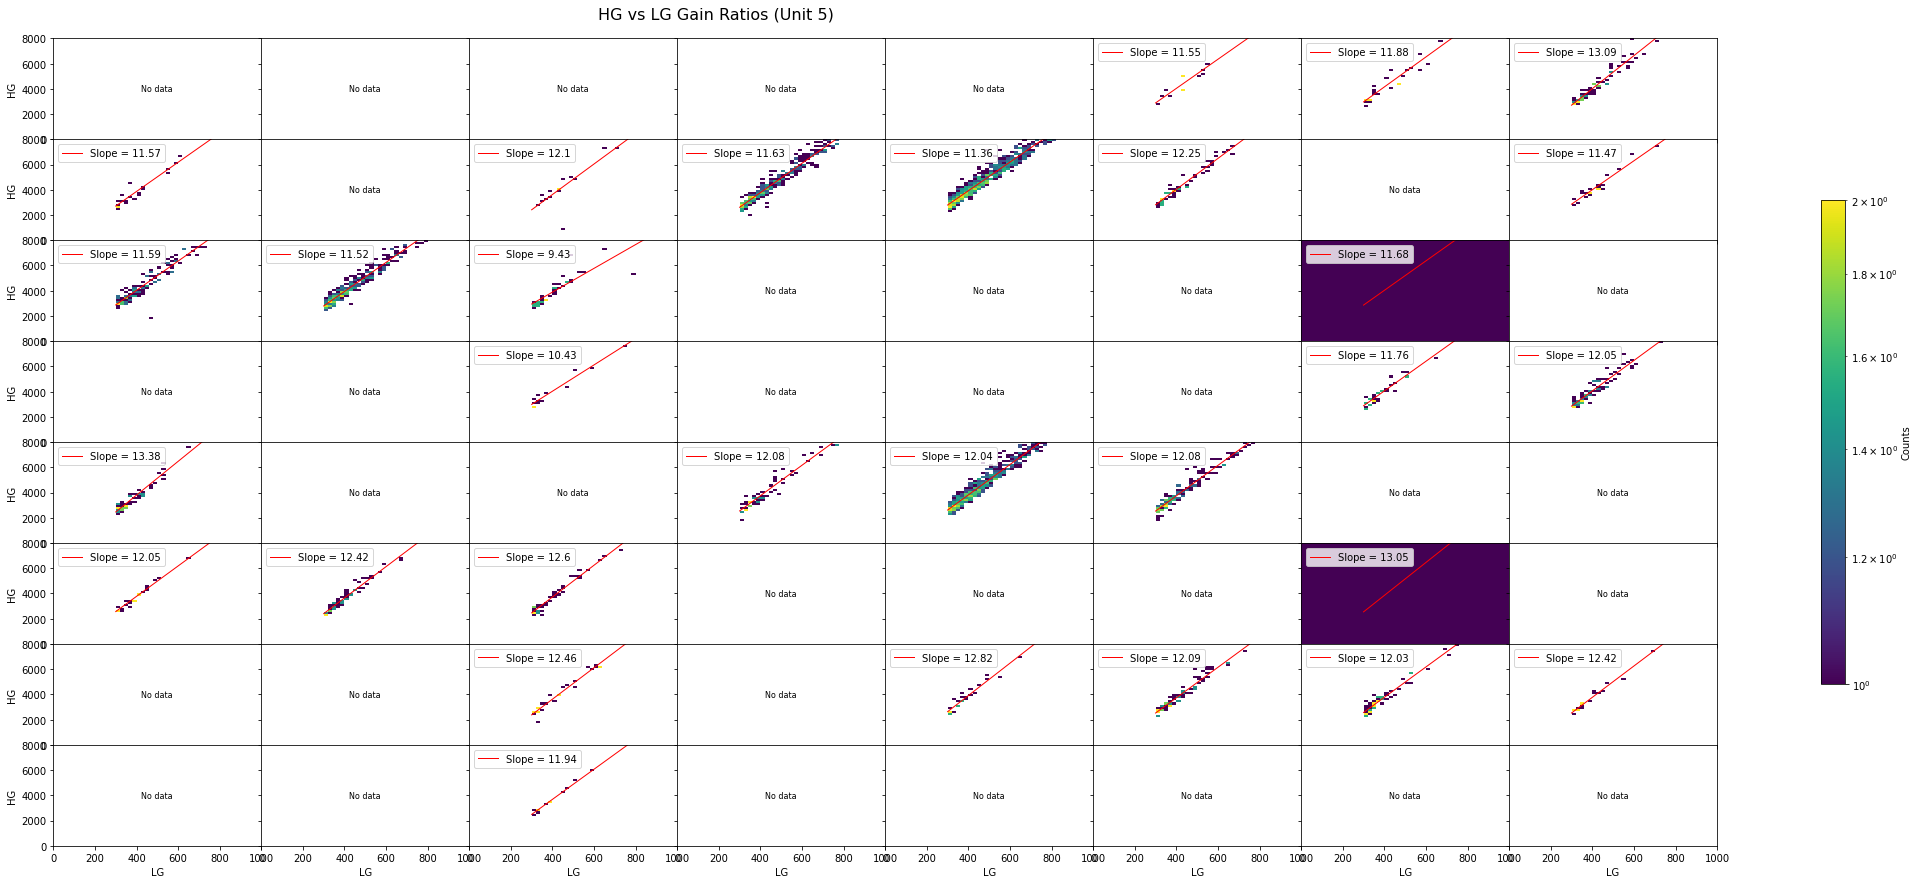

In [10]:
GainRatios = []
for i in range(6):
    analyze_gain_ratios_unit(din, caen_unit=i, GainRatios=GainRatios)

In [28]:
GainRatios = np.array(GainRatios)
RatioAvg = np.average(GainRatios[GainRatios != 0])
GainRatios[GainRatios == 0] = RatioAvg

In [13]:
with open('../../genIII_data/JLab/Beam/1-63-60-HGLG.pkl', 'wb') as f:
    pickle.dump(GainRatios, f)

In [34]:
Ratios = []
for i in range(64*6):
    Ratios.append(np.average(GainRatios))

In [53]:
GainRatios = np.array(GainRatios)
RatioAvg = np.average(GainRatios[GainRatios > 6.5])
print(RatioAvg)

7.874104461386031


In [12]:
print(GainRatios)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.90657861887998, 11.902025687824644, 0.0, 0.0, 0.0, 11.925172794853866, 12.16287505482403, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.107904196382835, 8.684380339042319, 10.175366222344246, 9.14344666688012, 11.944886198905776, 11.768963833378352, 0.0, 0.0, 0.0, 12.08481875146623, 12.936956788743574, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.8099928812136, 12.793465046623806, 14.133503765712712, 7.562002673148003, 8.50720387380964, 12.374910109842473, 11.471995808604118, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.978391149078721, 12.21933032768885, 13.00325922371754, 13.745177935984106, 9.17573088330033, 9.534193982432107, 12.338309361821846, 11.56981503428963, 11.102349165340867, 0.0, 11.949122547269955, 11.668770353345176, 11.618955727824082, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.422974243175583, 11.56423027904987, 12.481234831778762, 14.65752